

# Project Overview

Objective:
Build a Convolutional Neural Network (CNN) that classifies potato leaf images into disease categories using the PlantVillage dataset.

Dataset:
PlantVillage (Potato leaf images with diseases) — from Kaggle: https://www.kaggle.com/datasets/arjuntejaswi/plant-village

Tools:

✔ Google Colab

✔ TensorFlow / Keras

✔ Python libraries: numpy, matplotlib, sklearn



In [28]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Upload and Load the Dataset

Uploaded Dataset to Google Drive


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
dataset_path = "/content/drive/MyDrive/PlantVillage_Potato"

In [31]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3

In [32]:
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32
)

Found 2153 files belonging to 3 classes.


# Prepare the Data

In [33]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [34]:
for image_batch, label_batch in dataset.take(1): # Shape of 1st image
    print(image_batch[0].shape)
    print(label_batch.numpy())

(224, 224, 3)
[0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0]


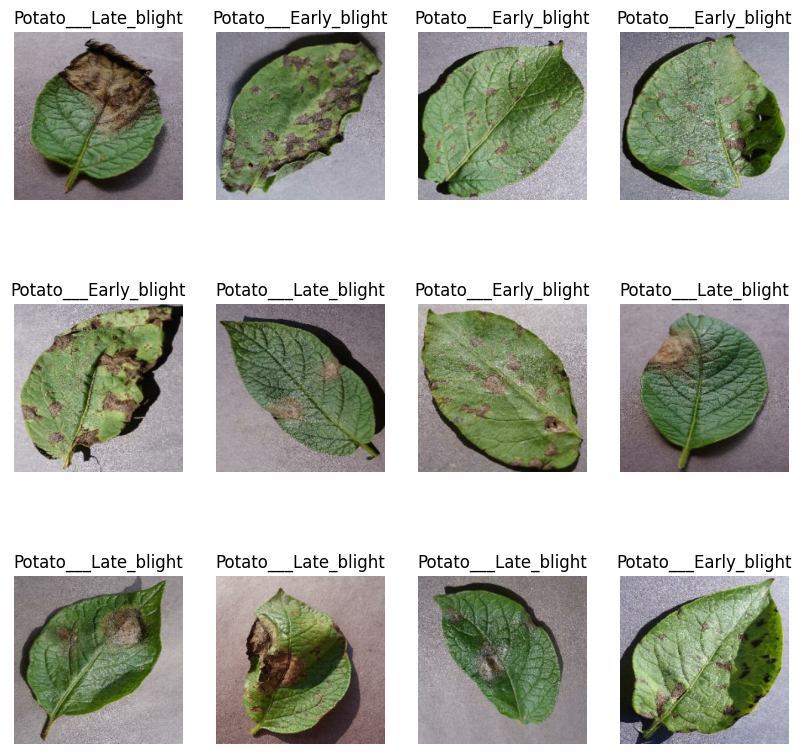

In [35]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Create Train-Validation Split

In [36]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [40]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [41]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Build the CNN Model

In [42]:
model = models.Sequential([
    layers.Input(shape=(224,224,3)),

    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(3, activation='softmax')
])


In [43]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Compile the Model

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses. SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

# Train the Model

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # watch validation performance
    patience=5,              # wait 5 epochs before stopping
    restore_best_weights=True
)

In [46]:
history = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.5195 - loss: 1.2126 - val_accuracy: 0.8281 - val_loss: 0.4609
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7929 - loss: 0.5253 - val_accuracy: 0.8281 - val_loss: 0.4341
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8606 - loss: 0.3814 - val_accuracy: 0.8958 - val_loss: 0.2790
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8792 - loss: 0.3085 - val_accuracy: 0.8542 - val_loss: 0.3417
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9241 - loss: 0.2179 - val_accuracy: 0.9427 - val_loss: 0.1693
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9189 - loss: 0.2043 - val_accuracy: 0.8854 - val_loss: 0.3738
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9375 - loss: 0.1656 - val_accuracy: 0.8594 - val_loss: 0.3595
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9275 - loss: 0.2108 - val_accuracy: 0.9219 -

# Model Evaluation

In [47]:
scors = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9546 - loss: 0.1334


# Plot Training Results

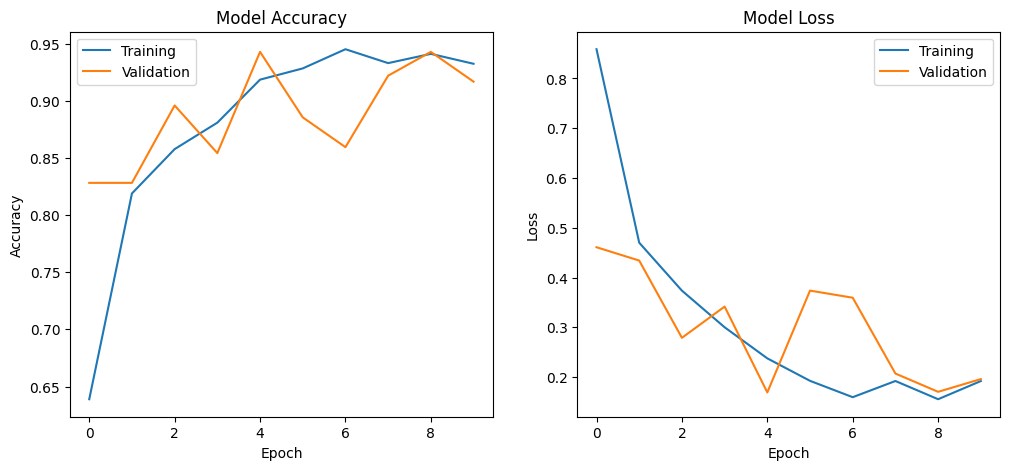

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,5))

# ---- Accuracy Plot ----
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'])

# ---- Loss Plot ----
plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])

plt.show()

# Evaluate on Unseen Images

In [49]:
import numpy as np

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


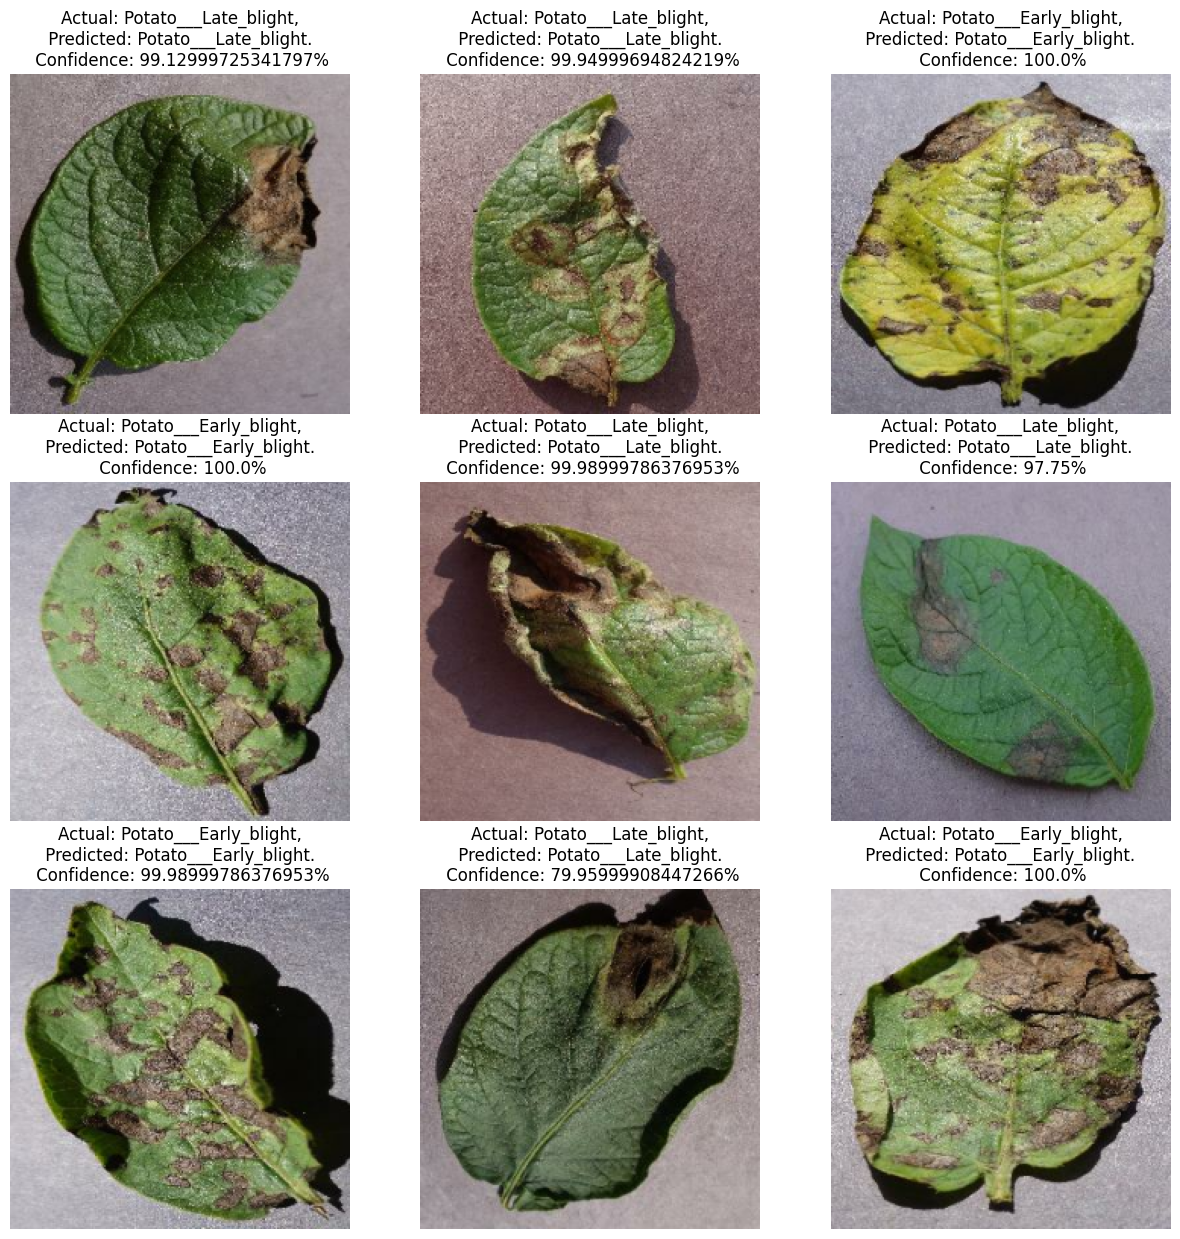

In [50]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i +1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}. \n Confidence: {confidence}%")

        plt.axis("off")

# Save the Model

In [51]:
model.save("potato_disease_classifier.h5")